In [20]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
import matplotlib.cm as cm

from matplotlib import pyplot as plt
from scipy.stats import binom
from utils import *

In [21]:
essentiality_colors = {
    'essential': qual_palette[9],
    'nonessential': qual_palette[3],
    'ambiguous': qual_palette[7], 
    'hcr': qual_palette[8]}

def map_fitness_color(fitness_diff):
    if fitness_diff < -1.0: # hcr
        return qual_palette[9]
    return greyish

In [22]:
# Grab the individual strain data
poolcount1_fname = "../data/2017_11_03_miseq_barSeq1/all.poolcount"
poolcount2_fname = "../data/2017_11_03_miseq_barSeq2/all.poolcount"

t0_label = 'test.S1'
hc_label = 'test.S2'  # high CO2
lc_label = 'test.S3'  # low CO2 = ambient

poolcount1_df = pd.read_csv(poolcount1_fname, sep='\t')
poolcount2_df = pd.read_csv(poolcount2_fname, sep='\t')

# Merge data from the two replicates
merge_on = ["barcode", "rcbarcode", "scaffold", "strand", "pos", "locusId"]
poolcount_df = poolcount1_df.merge(poolcount2_df, how='outer', on=merge_on)
cols2drop = set(poolcount_df.columns) - set(merge_on)
poolcount_df.drop(cols2drop, axis=1, inplace=True)

# Counts are the sum of the counts from two replicates.
poolcount_df[t0_label] = poolcount1_df[t0_label] + poolcount2_df[t0_label]
poolcount_df[hc_label] = poolcount1_df[hc_label] + poolcount2_df[hc_label]
poolcount_df[lc_label] = poolcount1_df[lc_label] + poolcount2_df[lc_label]

# Normalize to total number of reads. 
poolcount_df['t0_norm'] = poolcount_df[t0_label] / poolcount_df[t0_label].sum()
poolcount_df['lc_norm'] = poolcount_df[lc_label] / poolcount_df[lc_label].sum()
poolcount_df['hc_norm'] = poolcount_df[hc_label] / poolcount_df[hc_label].sum()

# Calculate difference in fitness on a single KO basis.
# Notice that the t0 cancels for this calculation.
poolcount_df['fitness_diff'] = np.log2(poolcount_df['lc_norm']) - np.log2(poolcount_df['hc_norm'])

# 9 is the max value because we grew cells for < 9 generations. 
poolcount_df.at[poolcount_df.fitness_diff == np.inf, 'fitness_diff'] = 9
poolcount_df.at[poolcount_df.fitness_diff == -np.inf, 'fitness_diff'] = -9

# Calculate the average fitness difference at each position
mean_fitness = poolcount_df.groupby('pos').fitness_diff.mean()
max_fitness = mean_fitness.max()
min_fitness = mean_fitness.min()

cnorm = matplotlib.colors.Normalize(vmin=-2.5, vmax=2.5, clip=True)
# cmapper = cm.ScalarMappable(norm=cnorm, cmap=cm.plasma_r)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log2


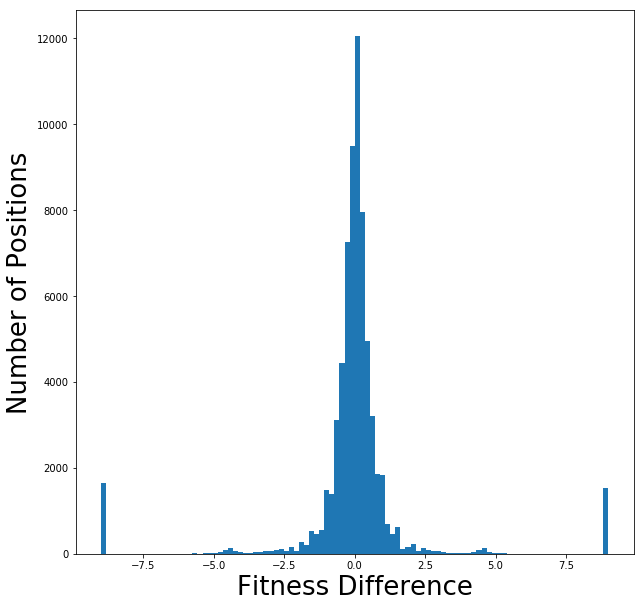

In [23]:
# Distribution of per-site fitness differences
figure = plt.figure(figsize=(10,10))
non_nan_fit = mean_fitness[mean_fitness.notnull()].values
plt.hist(non_nan_fit, bins=100)
plt.xlabel('Fitness Difference', fontsize=26)
plt.ylabel('Number of Positions', fontsize=26)

plt.show()

In [24]:
gbFile = "../data/Halo/HaloGenome.gb"
outfile = "../data/Halo/haloGeneNameConvertionTable.csv"
gb = list(SeqIO.parse(gbFile, "genbank"))

cds = [x for x in gb[0].features if x.type == 'CDS']

info = [[x.qualifiers.get('locus_tag')[0],x.qualifiers.get('old_locus_tag'),x.qualifiers.get('gene'),
         x.qualifiers.get('product'),x.qualifiers.get('protein_id'),x.qualifiers.get('db_xref')] for x in cds]
genes_df = pd.DataFrame(columns=['locusId','old_locus_tag','gene','product','protein_id','giNum'],data=info)
genes_df.protein_id=[x[0] if x else "" for x in genes_df.protein_id]
genes_df.giNum=[x[0].split(':')[1] if x else "" for x in genes_df.giNum]
genes_df.to_csv(outfile)

In [40]:
# Write some stuff to csv for SI
to_sup = small_log_df.drop('sysName',axis=1)
converter_df = pd.read_csv('../data/Halo/haloGeneNameConvertionTable.csv')[['locusId','protein_id','giNum']]
to_sup = converter_df.merge(to_sup,how='right',on='locusId')
to_print = to_sup.rename(columns={'locusId': 'Locus Id',
                       'protein_id': 'NCBI Accession number',
                       'giNum': 'NCBI gi number',
                       'desc': 'Gene description',
                      'HighCO2Log_1': 'High CO2 fitness replicate 1',
                       'LowCO2Log_1': 'Low CO2 fitness replicate 1',
                       'HighCO2Log_2': 'High CO2 fitness replicate 2',
                       'LowCO2Log_2': 'Low CO2 fitness replicate 2',
                        'HighCO2Err_1':'High CO2 error replicate 1',
                                  'LowCO2Err_1':'Low CO2 error replicate 1',
                                  'HighCO2Err_2':'High CO2 error replicate 2',
                                  'LowCO2Err_2':'High CO2 error replicate 2',
                      'hcr': 'Has HCR phenotype',})
to_print.to_csv('fig2/Fig2STable1.csv')

to_print

,Locus Id,NCBI Accession number,NCBI gi number,Gene description,High CO2 fitness replicate 1,Low CO2 fitness replicate 1,High CO2 fitness replicate 2,Low CO2 fitness replicate 2,High CO2 error replicate 1,Low CO2 error replicate 1,High CO2 error replicate 2,High CO2 error replicate 2,Has HCR phenotype
0,HNEAP_RS00025,WP_041600303.1,7.538447e+08,DNA replication and repair protein RecF,-0.216730,-0.266270,-0.303316,-0.373505,0.099470,0.096162,0.092793,0.095541,False
1,HNEAP_RS00035,WP_012822908.1,5.025851e+08,LemA family protein,-0.295904,-0.209298,-0.116786,0.034290,0.087119,0.083117,0.082399,0.080472,False
2,HNEAP_RS00040,WP_012822909.1,5.025851e+08,hypothetical protein,0.015524,-0.083013,-0.013024,0.041556,0.065279,0.064071,0.061627,0.062566,False
3,HNEAP_RS00045,WP_012822910.1,5.025851e+08,exodeoxyribonuclease III,-0.039378,-0.074868,-0.058519,-0.135996,0.112926,0.109980,0.109769,0.112772,False
4,HNEAP_RS00050,WP_012822911.1,5.025851e+08,ABC transporter permease,-0.140119,-0.100946,0.034305,-0.045147,0.049104,0.047132,0.045412,0.046548,False
5,HNEAP_RS00055,WP_049772428.1,9.086284e+08,ABC transporter,0.015082,0.008588,-0.117107,-0.055577,0.068078,0.065763,0.064913,0.064604,False
6,HNEAP_RS00060,WP_012822913.1,5.025851e+08,arylesterase,-0.206201,-0.164501,-0.154394,-0.150414,0.086871,0.083331,0.080798,0.081758,False
7,HNEAP_RS00065,WP_012822914.1,5.025851e+08,DUF559 domain-containing protein,0.105323,0.145502,0.198655,0.062234,0.110066,0.106069,0.100310,0.104320,False
8,HNEAP_RS00070,WP_012822915.1,5.025851e+08,IS110 family transposase,-0.018964,0.047808,0.086911,0.013681,0.057686,0.055370,0.052733,0.054088,False
9,HNEAP_RS00075,WP_012822917.1,5.025851e+08,prepilin-type cleavage/methylation domain-cont...,0.526258,0.141931,0.732353,0.359351,0.093595,0.095747,0.094308,0.100267,False


In [39]:
labeled_stuff = [
    ('HNEAP_RS04625', 'Csos1A'),
    ('HNEAP_RS04620', 'Csos1B'),
    ('HNEAP_RS04630', 'Csos1C'),
    ('HNEAP_RS04635', 'Csos4B'),
    ('HNEAP_RS04640', 'Csos4A'),
    ('HNEAP_RS04650', 'Csos2'),
    ('HNEAP_RS04660', 'CbbL'),
    ('HNEAP_RS04655', 'CbbS'),
    ('HNEAP_RS04645', 'CsosCA'),
    ('HNEAP_RS04565','Csos1D'),
    ('HNEAP_RS01030','DabA2'),
    ('HNEAP_RS01035','DabB2'),
    ('HNEAP_RS01040','LysR'),
    ('HNEAP_RS04615','acRAF'),
    ('HNEAP_RS05490','LysR'),
    ('HNEAP_RS07320','Crp/Fnr'),
    ('HNEAP_RS04585','DabA1'),
    ('HNEAP_RS04595','DabB1'),
    ('HNEAP_RS04575','CbbQ'),
    ('HNEAP_RS04600','CbbO'),
    ('HNEAP_RS04610','ParA'),
    ('HNEAP_RS04580','p-II'),
    ('HNEAP_RS04605','unk.'),
    ('HNEAP_RS04590','unk.'),
    ('HNEAP_RS04570','unk.'),
]
print(len(labeled_stuff))
labeling = dict(labeled_stuff)
trimmed = to_sup[to_sup.locusId.isin(labeling.keys())]
trimmed = trimmed.drop(['HighCO2Log_1','LowCO2Log_1','HighCO2Log_2','LowCO2Log_2',
                       'HighCO2Err_1','LowCO2Err_1','HighCO2Err_2','LowCO2Err_2'],axis=1)
trimmed.desc = trimmed.locusId.map(labeling)
to_print = trimmed.rename(columns={'locusId': 'Locus Id',
                       'protein_id': 'NCBI Accession number',
                       'giNum': 'NCBI gi number',
                       'desc': 'Gene description',
#                       'HighCO2Log_1': 'High CO2 fitness replicate 1',
#                        'LowCO2Log_1': 'Low CO2 fitness replicate 1',
#                        'HighCO2Log_2': 'High CO2 fitness replicate 2',
#                        'LowCO2Log_2': 'Low CO2 fitness replicate 2',
                      'hcr': 'Has HCR phenotype',}).reset_index(drop=True).round(2)
to_print.to_csv('fig2/genesOfIntrest.csv')
to_print

25


,Locus Id,NCBI Accession number,NCBI gi number,Gene description,Has HCR phenotype
0,HNEAP_RS01030,WP_012823110.1,5.025853e+08,DabA2,True
1,HNEAP_RS01035,WP_012823111.1,5.025853e+08,DabB2,True
2,HNEAP_RS01040,WP_012823112.1,5.025853e+08,LysR,True
3,HNEAP_RS04565,WP_012823782.1,5.025860e+08,Csos1D,False
4,HNEAP_RS04570,WP_012823783.1,5.025860e+08,unk.,False
5,HNEAP_RS04575,WP_012823784.1,5.025860e+08,CbbQ,False
6,HNEAP_RS04580,WP_012823785.1,5.025860e+08,p-II,False
7,HNEAP_RS04585,WP_012823786.1,5.025860e+08,DabA1,True
8,HNEAP_RS04590,WP_012823787.1,5.025860e+08,unk.,False
9,HNEAP_RS04595,WP_012823788.1,5.025860e+08,DabB1,True


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is dep

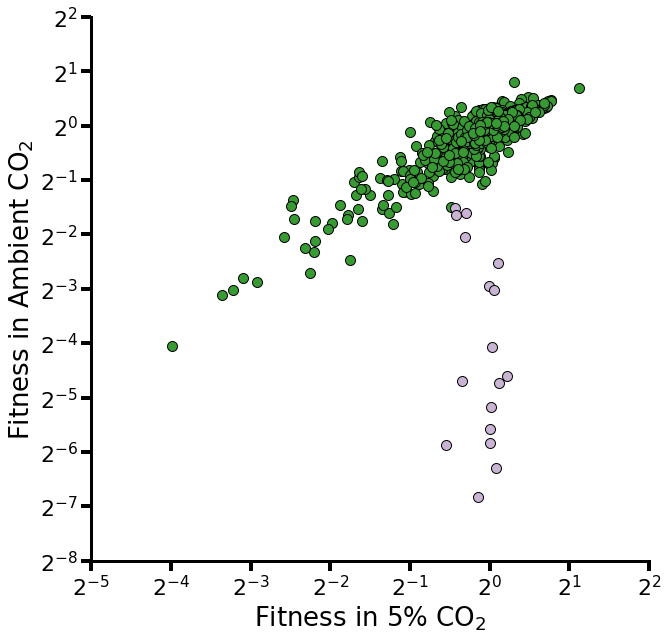

In [27]:
# TODO(JD): move annotations a bit for clarity
iCol = essentiality_colors['nonessential']
aCol = essentiality_colors['hcr']

fig,ax = plt.subplots(figsize=(10,10), frameon=False)

labeled_stuff = [
    ('HNEAP_RS04625', 'Csos1A', 0.11,-4.5),
    ('HNEAP_RS04620', 'Csos1B', -0.1,-1.6),
    ('HNEAP_RS04630', 'Csos1C', 0,-7),
    ('HNEAP_RS04635', 'Csos4B', 0.1,-5.9),
    ('HNEAP_RS04640', 'Csos4A', -1.5,-6.5),
    ('HNEAP_RS04650', 'Csos2', 0.1,-6.4),
    ('HNEAP_RS04660', 'CbbL', -0.9,-5.2),
    ('HNEAP_RS04655', 'CbbS', 0,-4.1),
    ('HNEAP_RS04645', 'CsosCA', 0.15,-5),
    ('HNEAP_RS04565','Csos1D', -0.05,-1.15),
    ('HNEAP_RS01030','DabA2', 0.1,-3.3),
        ('HNEAP_RS01035','DabB2',1,1),
    ('HNEAP_RS01040','LysR', 0.15,-2.6),
    ('HNEAP_RS04615','acRAF', -1.5,-4), #Pterin-4a-carbinolamine dehydratase
    ('HNEAP_RS05490','LysR', -0.8,-6),
    ('HNEAP_RS07320','Crp/Fnr', 0,-2.1),
    ('HNEAP_RS04585','DabA1', -1.5,-2.1),
        ('HNEAP_RS04595','DabB1',1,1),
#         ('HNEAP_RS05865','TPR_16',1,1),#Tetratricopeptide TPR_2 repeat protein
#     'HNEAP_RS05380':'Lytic transglycosylase catalytic',
#     'HNEAP_RS08465':'N-acetylmuramyl-L-alanine amidase, negative regulator of AmpC, AmpD'
]

# for gene,label,x,y in labeled_stuff:
#     row = small_log_df[small_log_df.locusId == gene]
#     plt.text(row.HighCO2Log_1,row.LowCO2Log_1,label,fontsize=20)

plt.scatter(small_diff_df.HighCO2Log_1, small_diff_df.LowCO2Log_1, c=iCol, edgecolors='k', s=100)
plt.scatter(big_diff_df.HighCO2Log_1, big_diff_df.LowCO2Log_1, c=aCol, edgecolors='k', s=100)


plt.xlabel('Fitness in 5% CO$_2$')
plt.ylabel('Fitness in Ambient CO$_2$')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

locs,labels = plt.xticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.xticks(locs, ticks, fontsize=22)

locs,labels = plt.yticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.yticks(locs,ticks, fontsize=22)
        
plt.savefig('fig2/fig2B.eps',format='eps',bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is dep

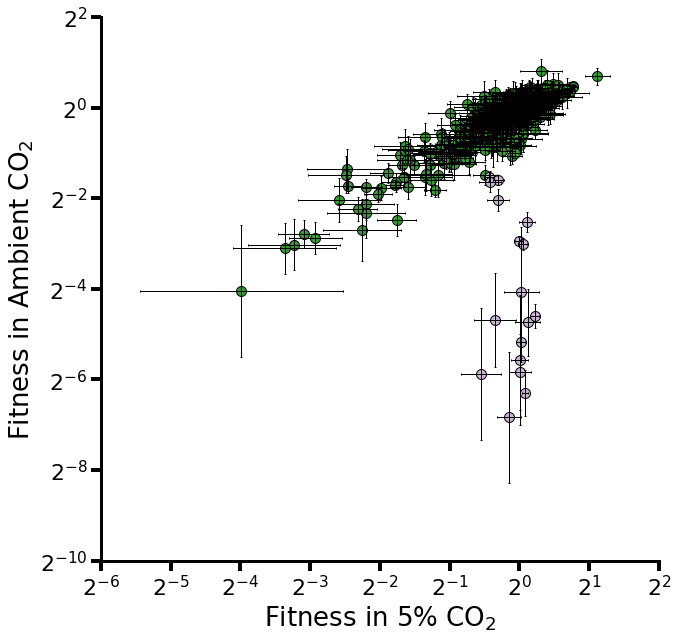

In [42]:
# TODO(JD): move annotations a bit for clarity
iCol = essentiality_colors['nonessential']
aCol = essentiality_colors['hcr']

fig,ax = plt.subplots(figsize=(10,10), frameon=False)

plt.scatter(small_diff_df.HighCO2Log_1, small_diff_df.LowCO2Log_1, c=iCol, edgecolors='k', s=100)
plt.scatter(big_diff_df.HighCO2Log_1, big_diff_df.LowCO2Log_1, c=aCol, edgecolors='k', s=100)
plt.errorbar(small_log_df.HighCO2Log_1,small_log_df.LowCO2Log_1,ecolor='k',elinewidth=1,capsize=1,
             xerr=small_log_df.HighCO2Err_1,yerr=small_log_df.LowCO2Err_1, linestyle="None")


plt.xlabel('Fitness in 5% CO$_2$')
plt.ylabel('Fitness in Ambient CO$_2$')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

locs,labels = plt.xticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.xticks(locs, ticks, fontsize=22)

locs,labels = plt.yticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.yticks(locs,ticks, fontsize=22)
        
plt.savefig('fig2/rep1_fitness_sup.eps',format='eps',bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is dep

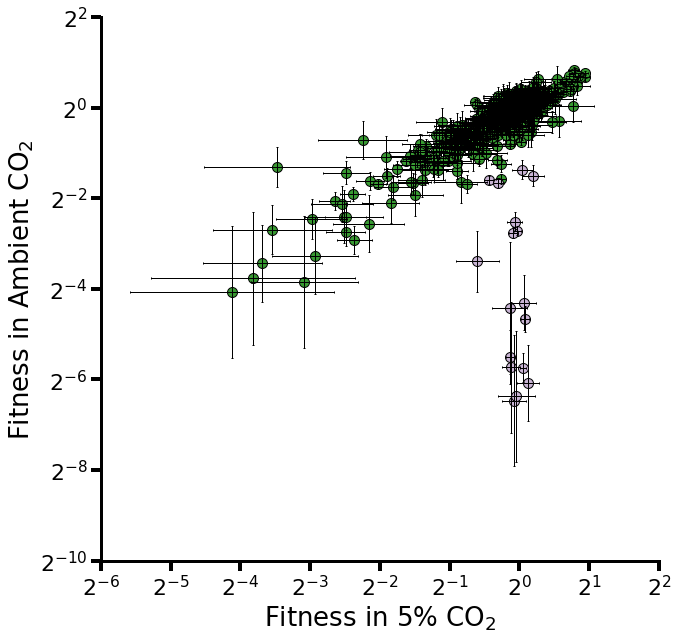

In [44]:
# TODO(JD): move annotations a bit for clarity
iCol = essentiality_colors['nonessential']
aCol = essentiality_colors['hcr']

fig,ax = plt.subplots(figsize=(10,10), frameon=False)

# for gene,label,x,y in labeled_stuff:
#     row = small_log_df[small_log_df.locusId == gene]
#     plt.text(row.HighCO2Log_1,row.LowCO2Log_1,label,fontsize=20)

plt.scatter(small_diff_df.HighCO2Log_2, small_diff_df.LowCO2Log_2, c=iCol, edgecolors='k', s=100)
plt.scatter(big_diff_df.HighCO2Log_2, big_diff_df.LowCO2Log_2, c=aCol, edgecolors='k', s=100)
plt.errorbar(small_log_df.HighCO2Log_2,small_log_df.LowCO2Log_2,ecolor='k',elinewidth=1,capsize=1,
             xerr=small_log_df.HighCO2Err_2,yerr=small_log_df.LowCO2Err_2, linestyle="None")


plt.xlabel('Fitness in 5% CO$_2$')
plt.ylabel('Fitness in Ambient CO$_2$')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

locs,labels = plt.xticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.xticks(locs, ticks, fontsize=22)

locs,labels = plt.yticks()
ticks=['2$^{'+str(int(x))+'}$' for x in locs]
plt.yticks(locs,ticks, fontsize=22)
        
plt.savefig('fig2/rep2_fitness_sup.eps',format='eps',bbox_inches='tight')
plt.show()

In [30]:
# TODO(JD): put annotations in here for figures below.
short_names = {'HNEAP_RS04610': 'ParA',
               'HNEAP_RS04615': 'acRAF',
               'HNEAP_RS04635': 'csos4B',
               'HNEAP_RS04605': 'unk.',
               'HNEAP_RS04585': 'DabA1',
               'HNEAP_RS04575': 'CbbQ',
               'HNEAP_RS04580': 'P-II',
               'HNEAP_RS04680': 'unk.',
               'HNEAP_RS04620': 'csos1B',
               'HNEAP_RS04625': 'csos1A',
               'HNEAP_RS04675': 'transporter',
               'HNEAP_RS04565': 'csos1D',
               'HNEAP_RS04685': 'NnrS',
               'HNEAP_RS04640': 'csos4A',
               'HNEAP_RS04600': 'cbbO',
               'HNEAP_RS04645': 'csoCA',
               'HNEAP_RS04555': 'TS',
               'HNEAP_RS04690': 'unk.',
               'HNEAP_RS04670': 'DUF302',
               'HNEAP_RS04595': 'DabB1',
               'HNEAP_RS04655': 'rbcS',
               'HNEAP_RS04570': 'unk.',
               'HNEAP_RS04630': 'csos1C',
               'HNEAP_RS04665': 'Cu-transporter',
               'HNEAP_RS04560': 'lgt',
               'HNEAP_RS04660': 'rbcL',
               'HNEAP_RS04590': 'unk.',
               'HNEAP_RS04650': 'csos2',
               'HNEAP_RS01020': 'GLUL',
               'HNEAP_RS01065': 'DUF839',
               'HNEAP_RS01030': 'DabA2',
               'HNEAP_RS01045': 'DUF3817',
               'HNEAP_RS01010': 'DNA-binding',
               'HNEAP_RS01050': 'PTH',
               'HNEAP_RS01025': 'TspO',
               'HNEAP_RS01055': 'unk.',
               'HNEAP_RS01015': 'kinase',
               'HNEAP_RS01035': 'DabB2',
               'HNEAP_RS01060': 'thioredoxin',
               'HNEAP_RS01040': 'LysR',
               'HNEAP_RS07310': 'unk.',
               'HNEAP_RS07320': 'Crp/Fnr',
               'HNEAP_RS07315': 'unk.',
               'HNEAP_RS07325': 'PP-ase',
               'HNEAP_RS05485': 'tRNA-Met',
               'HNEAP_RS12520': 'unk.',
               'HNEAP_RS05495': 'VWA',
               'HNEAP_RS05480': 'diguanylate cyclase',
               'HNEAP_RS05490': 'LysR'}

# Arrow parameters
width = 0.05
headwidth = 0.085
height = 1e-5
head_scale = 0.2
len_per_bp = 1e-4

essentiality_colors = {
    'essential': qual_palette[9],
    'nonessential': qual_palette[3],
    'ambiguous': qual_palette[7], 
    'hcr': qual_palette[8]}

thymidylate synthase
prolipoprotein diacylglyceryl transferase
microcompartments protein
hypothetical protein
CbbQ/NirQ/NorQ/GpvN family protein
nitrogen regulatory protein P-II
DUF2309 domain-containing protein
hypothetical protein
oxidoreductase
VWA domain-containing protein
hypothetical protein
ParA family protein
hypothetical protein
major carboxysome shell protein 1B
major carboxysome shell protein 1A
major carboxysome shell protein 1C
carboxysome peptide B
carboxysome peptide A
carboxysome shell carbonic anhydrase
hypothetical protein
ribulose bisphosphate carboxylase small subunit
ribulose bisphosphate carboxylase large chain
copper-translocating P-type ATPase


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


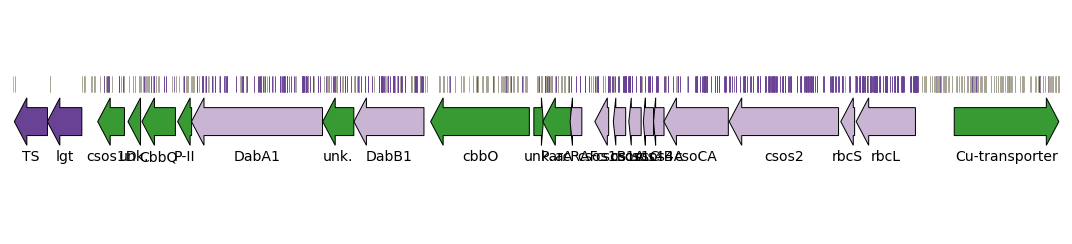

In [31]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (983594-14000,986794+8000)

length_longest_axis = (max(region)-min(region))*len_per_bp

y = 0.2

insert_color = qual_palette[1]

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
    gene_name = short_names[gene.locusId]
#     print(gene_name)
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)
    print(gene.desc)

fitnesses = mean_fitness.loc[insert_in_region.pos]
fitness_colors = [map_fitness_color(v) for v in fitnesses]
poses = (insert_in_region.pos - region_start) * len_per_bp
#fitness_colors = [cmapper.to_rgba(v) for v in fitnesses]
n_positions = len(poses)

#bottoms = [y+height+headwidth/2 + 0.045]*n_positions
#tops = bottoms + (height*insert_in_region.n_total)
#plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=fitness_colors, linewidth=0.75)

plt.xlim(0,length_longest_axis)

# print(dict(zip(genes_in_region.locusId, genes_in_region.desc)))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()

plt.savefig('fig2/fig2C_sub1.eps', format='eps', bbox_inches='tight')
plt.show()

DNA-binding response regulator
two-component sensor histidine kinase
glutamate--ammonia ligase
tryptophan-rich sensory protein
DUF2309 domain-containing protein
NADH dehydrogenase subunit 5
LysR family transcriptional regulator
DUF3817 domain-containing protein
aminoacyl-tRNA hydrolase
hypothetical protein
thioredoxin domain-containing protein


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


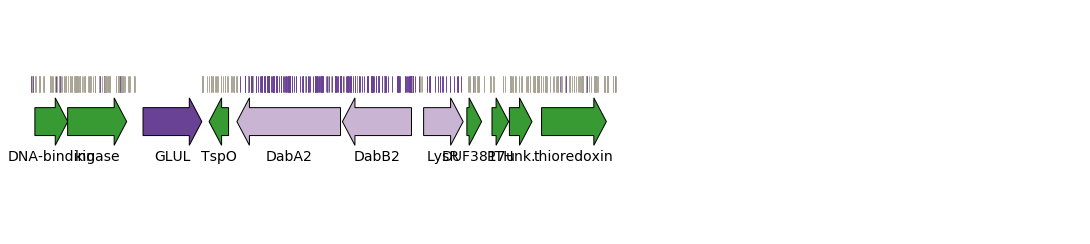

In [32]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (216936-5000,219419+6600)
y = 0.2

insert_color = qual_palette[1]

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
    gene_name = short_names[gene.locusId]
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)
    print(gene.desc)

fitnesses = mean_fitness.loc[insert_in_region.pos]
fitness_colors = [map_fitness_color(v) for v in fitnesses]
poses = (insert_in_region.pos - region_start) * len_per_bp
n_positions = len(poses)

#bottoms = [y+height+headwidth/2 + 0.045]*n_positions
#tops = bottoms + (height*insert_in_region.n_total)
#plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=fitness_colors, linewidth=0.75)

# print(dict(zip(genes_in_region.locusId, genes_in_region.desc)))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)



plt.xlim(0,length_longest_axis)
plt.tight_layout()

plt.savefig('fig2/fig1C_sub2.eps', format='eps', bbox_inches='tight')
plt.show()

sensor domain-containing diguanylate cyclase
tRNA-Met
LysR family transcriptional regulator
VWA domain-containing protein
hypothetical protein
{'HNEAP_RS05480': 'sensor domain-containing diguanylate cyclase', 'HNEAP_RS05485': 'tRNA-Met', 'HNEAP_RS05490': 'LysR family transcriptional regulator', 'HNEAP_RS05495': 'VWA domain-containing protein', 'HNEAP_RS12520': 'hypothetical protein'}


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


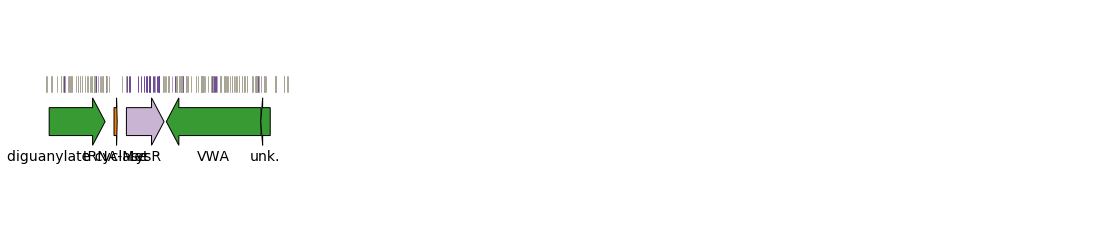

In [33]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (1179635-2000,1180537+3000)
y = 0.2

insert_color = qual_palette[1]


region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
#     gene_name = short_names[gene.locusId]
    gene_name = short_names.get(gene.locusId, 'Unk.')
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)
    print(gene.desc)

fitnesses = mean_fitness.loc[insert_in_region.pos]
fitness_colors = [map_fitness_color(v) for v in fitnesses]
poses = (insert_in_region.pos - region_start) * len_per_bp
n_positions = len(poses)

#bottoms = [y+height+headwidth/2 + 0.045]*n_positions
#tops = bottoms + (height*insert_in_region.n_total)
#plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=fitness_colors, linewidth=0.75)

print(dict(zip(genes_in_region.locusId, genes_in_region.desc)))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

length_longer_axis = ((986794+11000)- (983594-14000))*len_per_bp

plt.xlim(0,length_longest_axis)
plt.tight_layout()

plt.savefig('fig2/fig1C_sub3.eps', format='eps', bbox_inches='tight')
plt.show()

hypothetical protein
hypothetical protein
hypothetical protein
diguanylate phosphodiesterase


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


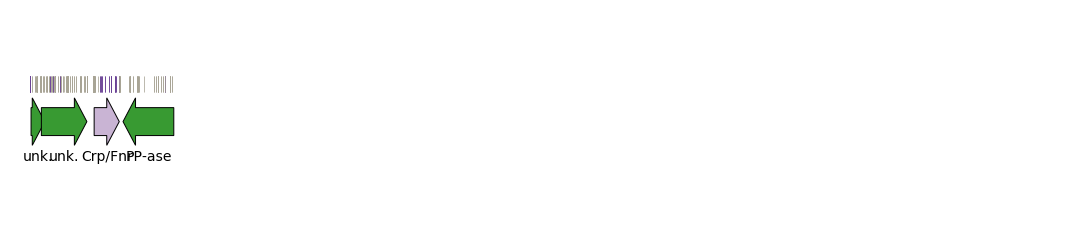

In [34]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (1575176 -2000,1575778+1350)
y = 0.2

insert_color = qual_palette[1]

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
#     gene_name = short_names[gene.locusId]
    gene_name = short_names.get(gene.locusId, 'Unk.')
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)
    print(gene.desc)


fitnesses = mean_fitness.loc[insert_in_region.pos]
fitness_colors = [map_fitness_color(v) for v in fitnesses]
poses = (insert_in_region.pos - region_start) * len_per_bp
n_positions = len(poses)

#bottoms = [y+height+headwidth/2 + 0.045]*n_positions
#tops = bottoms + (height*insert_in_region.n_total)
#plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=fitness_colors, linewidth=0.75)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

length_longer_axis = ((986794+11000)- (983594-14000))*len_per_bp

plt.xlim(0,length_longest_axis)
plt.tight_layout()

plt.savefig('fig2/fig1C_sub4.eps', format='eps', bbox_inches='tight')
plt.show()

**Getting to the bottom of csoS1D **

microcompartments protein


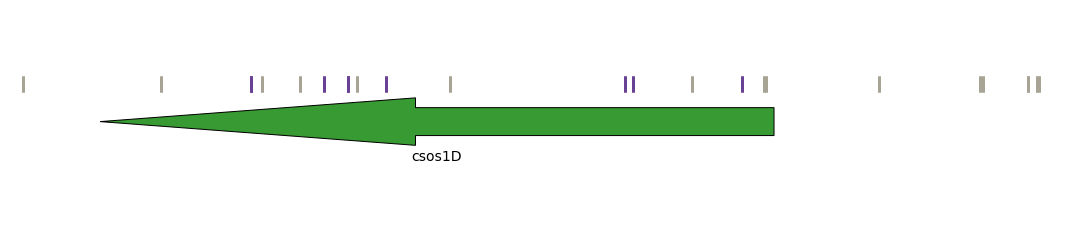

In [35]:
# Making Panel B

fig,ax = plt.subplots(figsize=(15, 3.5), frameon=False)

plt.ylim(0, 0.4)
region = (983594-12000,983594-11000)

length_longest_axis = (max(region)-min(region))*len_per_bp

y = 0.2

insert_color = qual_palette[1]

region_start, region_end = region
region_length = region_end - region_start

genes_in_region = essentiality_df[(essentiality_df.begin >= region_start) & 
                                  (essentiality_df.end <= region_end)]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]

for gene_idx in genes_in_region.index:
    gene = genes_in_region.loc[gene_idx]
    gene_name = short_names[gene.locusId]
#     print(gene_name)
    gene_length = gene.length_rep1
    gene_essentiality = essentiality_df.loc[gene_idx].essentiality
    length = gene_length * len_per_bp
    head_length = length*head_scale
    if length > 0.03:
        head_length = 0.03
    c = essentiality_colors[gene_essentiality]
    
    is_hcr = (small_log_df[small_log_df.locusId == gene.locusId].hcr).any()
    if is_hcr:
        c = essentiality_colors['hcr']

    gene_start = gene.begin
    gene_end = gene.end
    gene_strand = gene.strand

    if gene_strand == '+':
        start = (gene_start - region_start)*len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth, head_length=head_length, fill=True, facecolor=c)
        ax.add_artist(genePic)
        plt.text(start+length/2, y-0.07, gene_name, ha='center', fontsize=14)
    else:
        start = (gene_end - region_start) * len_per_bp
        genePic = matplotlib.patches.FancyArrow(
            start, y, -length, 0,
            width=width, length_includes_head=True,
            head_width=headwidth,
            head_length=head_length, fill=True,facecolor=c)
        ax.add_artist(genePic)
        plt.text(start-length/2, y-0.07, gene_name, ha='center', fontsize=14)
    print(gene.desc)

fitnesses = mean_fitness.loc[insert_in_region.pos]
fitness_colors = [map_fitness_color(v) for v in fitnesses]
poses = (insert_in_region.pos - region_start) * len_per_bp
#fitness_colors = [cmapper.to_rgba(v) for v in fitnesses]
n_positions = len(poses)

#bottoms = [y+height+headwidth/2 + 0.045]*n_positions
#tops = bottoms + (height*insert_in_region.n_total)
#plt.vlines(poses, bottoms, tops, colors='k')

bottoms = np.array([y+height+headwidth/2+0.01]*n_positions)
tops = bottoms + 0.03
plt.vlines(poses, tops, bottoms, colors=fitness_colors, linewidth=3)

plt.xlim(0,length_longest_axis)

# print(dict(zip(genes_in_region.locusId, genes_in_region.desc)))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()

plt.show()

In [36]:
csos1D_df = small_log_df[small_log_df.locusId=='HNEAP_RS04565']
csos1D_df

,locusId,sysName,desc,HighCO2Log_1,LowCO2Log_1,HighCO2Log_2,LowCO2Log_2,HighCO2Err_1,LowCO2Err_1,HighCO2Err_2,LowCO2Err_2,hcr
632,HNEAP_RS04565,HNEAP_RS04565,microcompartments protein,0.015781,-0.823426,-0.263101,-1.237303,0.158376,0.184949,0.147435,0.186313,False


In [37]:
csos1D_df['rep1'] = csos1D_df.LowCO2Log_1-csos1D_df.HighCO2Log_1
csos1D_df['rep2'] = csos1D_df.LowCO2Log_2-csos1D_df.HighCO2Log_2
csos1D_df

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,locusId,sysName,desc,HighCO2Log_1,LowCO2Log_1,HighCO2Log_2,LowCO2Log_2,HighCO2Err_1,LowCO2Err_1,HighCO2Err_2,LowCO2Err_2,hcr,rep1,rep2
632,HNEAP_RS04565,HNEAP_RS04565,microcompartments protein,0.015781,-0.823426,-0.263101,-1.237303,0.158376,0.184949,0.147435,0.186313,False,-0.839207,-0.974203


In [38]:
D=rep_df2[rep_df2.locusId=='HNEAP_RS04565']
region_start = D.begin.values[0]
region_end = D.end.values[0]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]
fitnesses = mean_fitness.loc[insert_in_region.pos].drop_duplicates()

print('fitness values calculated by feba script\nRep1: %f\nRep2: %f'%(csos1D_df.rep1,csos1D_df.rep2))
print('average: %f\n'%np.average([csos1D_df.rep1.values[0],csos1D_df.rep2.values[0]]))

print('fitness values from average insertion fitnesses we calculated above')
print()
print('Calculated using the whole gene')
# print('Average fitness value of an insertion in csos1D including infs as 9s: %f'%fitnesses.mean())
fitnesses_stripped = fitnesses[np.abs(fitnesses)!=9]
print('Average fitness value of an insertion in csos1D dropping infs: %f'%fitnesses_stripped.mean())

region_start = (D.begin+(D.length*0.1)).values[0]
region_end = (D.end-(D.length*0.1)).values[0]
insert_in_region = total_pool_df[(total_pool_df.pos >= region_start) & 
                                 (total_pool_df.pos <= region_end)]
fitnesses = mean_fitness.loc[insert_in_region.pos].drop_duplicates()
print()
print('Calculated using the middle 80%')
# print('Average fitness value of an insertion in csos1D including infs as 9s: %f'%fitnesses.mean())
fitnesses_stripped = fitnesses[np.abs(fitnesses)!=9]
print('Average fitness value of an insertion in csos1D dropping infs: %f'%fitnesses_stripped.mean())


fitness values calculated by feba script
Rep1: -0.839207
Rep2: -0.974203
average: -0.906705

fitness values from average insertion fitnesses we calculated above

Calculated using the whole gene
Average fitness value of an insertion in csos1D dropping infs: -0.828428

Calculated using the middle 80%
Average fitness value of an insertion in csos1D dropping infs: -1.063591
